10
alpha= 0.050
EFDM Price :  0.6571
Exact BS Price :  0.6889


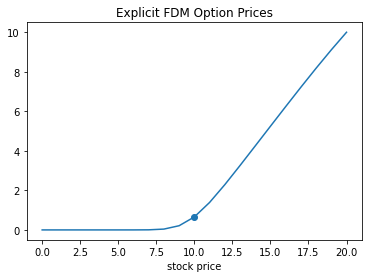

In [16]:
# Black and Scholes Option Price Using EFDM written at 2022/06/28

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def BSprice(PutCall, x0, T, K, rf, q, sigma):
    d1 =(1/(sigma*np.sqrt(T)))*(np.log(x0/K) + (rf - q + 0.5*sigma**2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(x0/K) + (rf - q - 0.5*sigma**2)*T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    Nd1m = norm.cdf(-d1)
    Nd2m = norm.cdf(-d2)
    
    if PutCall == 'C':
        price1 = x0*np.exp(-q*T)*Nd1 - K*np.exp(-rf*T)*Nd2
        price2 = np.exp(-q*T)*Nd1
    elif PutCall =='P':
        price1 = K*np.exp(-rf*T)*Nd2m - x0*np.exp(-q*T)*Nd1m
        price2 = -np.exp(-q*T)*Nd1m

    # price = [price1, price2]=[price,delta]
    price = np.zeros((1,2))
    price[0,0] = price1
    price[0,1] = price2
    return price                # returns array


def EFDM(PutCall,xmin,K,rf,q,sigma,dt,dx,N,M):
    xh = np.array(list(range(M+1)))                                         # number of node: M+1 from 0 to M
    tk = np.array(list(range(N+1)))

    v = np.zeros((N+1,M+1))                                                 # value at note (shape:(N+1,M+1))
    
    # BC at expiration (n=0)
    if PutCall == 'C':
        v[0,0:M+1] = np.maximum(xmin + xh*dx - K, 0)
    elif PutCall =='P':
        v[0,0:M+1] = np.maximum(K - (xmin + xh*dx), 0)
        
    # BC at x = Smax or Smin (m=M or m=0)
    if PutCall =='C':
        v[0:N+1,0] = 0                                                         # call value when underlying is 0
        v[0:N+1,M] = (xmin + M*dx - K)*np.exp(-q*tk*dt)                        # call value when underlying is large 
    elif PutCall == 'P':
        v[0:N+1,0] = K*np.exp(-rf*tk*dt)                                        # put value when underlying is 0
        v[0:N+1,M] = 0                                                          # put value when underlying is large 

    # Coefficients of matrix for EFDM
    DF = 1/(1 + dt*rf)
    a = DF*(1 - dt*(sigma**2)*(xh**2))
    b = DF*(dt/2)*(-(rf-q)*xh + (sigma**2)*(xh**2))
    c = DF*(dt/2)*((rf-q)*xh + (sigma**2)*(xh**2))
    
    # Finding value at N+1 
    for i in range (0,N):
        v[i+1,1:M] = np.multiply(b[1:M],v[i,0:M-1]) + np.multiply(a[1:M],v[i,1:M]) + np.multiply(c[1:M],v[i,2:M+1])
        
    price = np.zeros(M+1)
    price = v[N,0:M+1]
    return price

PutCall = 'C'
x0 = 10
K = 10
rf = 0.05
q = 0
sigma = 0.2
T = 0.5

xmin = 0
xmax = x0*(1 + 5*sigma)       # Smax = s0*(1 + 5*sigma)
N = 10                        # numer of time point
M = 20                        # numer of stock price point 
dx = (xmax-xmin)/M            # S-mesh size
dt = T/N                      # t-mesh size

alpha = dt/(dx)**2            # alpha < 1/2 for stability
x0tag = 0
for i in range(M + 1):
    if i*dx < x0:
        x0tag += 1
print(x0tag)

# Plain Vanillar Option 
EFDMprice = EFDM(PutCall,xmin,K,rf,q,sigma,dt,dx,N,M)

BSEprice = BSprice(PutCall,x0,T,K,rf,q,sigma)

print('alpha=',"%.3f" %alpha)
print('EFDM Price : ', "%.4f" %EFDMprice[x0tag])
print('Exact BS Price : ', "%.4f" %BSEprice[0,0])

# Plotting
x = np.linspace(xmin, xmax, M+1)
plt.xlabel('stock price')
plt.title('Explicit FDM Option Prices')
plt.plot(x, EFDMprice[:])
plt.scatter(x[x0tag], EFDMprice[x0tag])
plt.show()

Delta at current price :  0.7315
Exact Delta :  0.5977


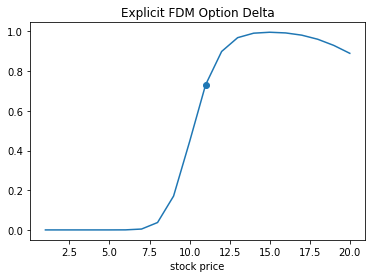

In [17]:
# Delta calculation

delta = (EFDMprice[1:M+1] - EFDMprice[0:M])/dx
print('Delta at current price : ', "%.4f" %delta[x0tag])

# BS CLosed-form Delta
print('Exact Delta : ', "%.4f" %BSEprice[0,1])

x = np.linspace(xmin+1, xmax, M)
plt.xlabel('stock price')
plt.title('Explicit FDM Option Delta')
plt.scatter(x[x0tag], delta[x0tag])
plt.plot(x,delta[:])
plt.show()


In [14]:
# Error
Error = BSEprice[0,0] - EFDMprice[x0tag] 
relError = (Error/BSEprice[0,0])*100
print('absolute error', "%.3f" %Error)
print('relative error', "%.3f" %relError, '%')

absolute error 0.032
relative error 4.607 %
